# Análisis de oscilaciones en estrellas roAp

En 1960 Robert Leighton y sus colegas del Observatorio del Monte Wilson en California realizaron un descubrimiento crucial al observar oscilaciones periódicas en la superficie del Sol con un periodo de aproximadamente 5 minutos. Esta observación se publicó en 1962 y marcó el comienzo formal del estudio de las oscilaciones solares.

Años después se desarrollaron teorías para explicar las oscilaciones solares. Las oscilaciones solares nos revelan información crítica sobre la estructura interna del Sol, incluida la distribución de la temperatura, la densidad y la velocidad de rotación en diferentes profundidades. Estos avances sentaron las bases para la **astrosismología**, la rama de la astronomía que estudia las oscilaciones en otras estrellas.

Las estrellas Ap de oscilación rápida (estrellas roAp) son un subtipo de la clase de estrellas A peculiares que exhiben variaciones fotométricas o de velocidad radial rápidas en escalas de tiempo cortas. Las primeras estrellas roAp fueron descubiertas por Kurtz en 1982. El análisis de sus oscilaciones nos permite obtener información valiosa respecto a su estructura interna. 

El objetivo de este trabajo es precisamente analizar las oscilaciones de algunas estrellas de este tipo y determinar elementos que los constituyen, como su temperatura y su gravedad.

## Parte 1: Preparación de datos

Las estrellas asignadas para este análisis son las siguientes:

In [1]:
ids = ["TIC 101624823", "TIC 165052884", "TIC 233200244", "TIC 158271090", "TIC 298052991", "TIC 435263600"]

Tomemos la primera estrella correspondiente:

In [2]:
import lightkurve as lk
import astropy

In [3]:
search_result = lk.search_lightcurve(ids[0], mission="TESS")
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 22,2020,SPOC,120,101624823,0.0
1,TESS Sector 49,2022,SPOC,20,101624823,0.0
2,TESS Sector 49,2022,SPOC,120,101624823,0.0
3,TESS Sector 22,2020,TESS-SPOC,1800,101624823,0.0
4,TESS Sector 49,2022,TESS-SPOC,600,101624823,0.0
5,TESS Sector 22,2020,QLP,1800,101624823,0.0
6,TESS Sector 49,2022,QLP,600,101624823,0.0
7,TESS Sector 22,2020,CDIPS,1800,101624823,0.0
8,TESS Sector 49,2022,CDIPS,1800,101624823,0.0


Tenemos bases de datos de distintos tipos, autores y con tiempos de exposición distintos. En este caso tomamos aquellos correspondientes a SPOC y con tiempos de exposición de 120s:

In [4]:
search_result = lk.search_lightcurve(ids[0], mission="TESS", author="SPOC",exptime="120")

Ahora descargamos los datos y hacemos un análisis

In [11]:
import pandas as pd

In [12]:
#Descargamos datos de las curvas de luz y eliminamos posible ruido
lightcurves = [item.download().remove_nans().remove_outliers().flatten() for item in search_result]

Veamos una gráfica de las curvas de luz

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

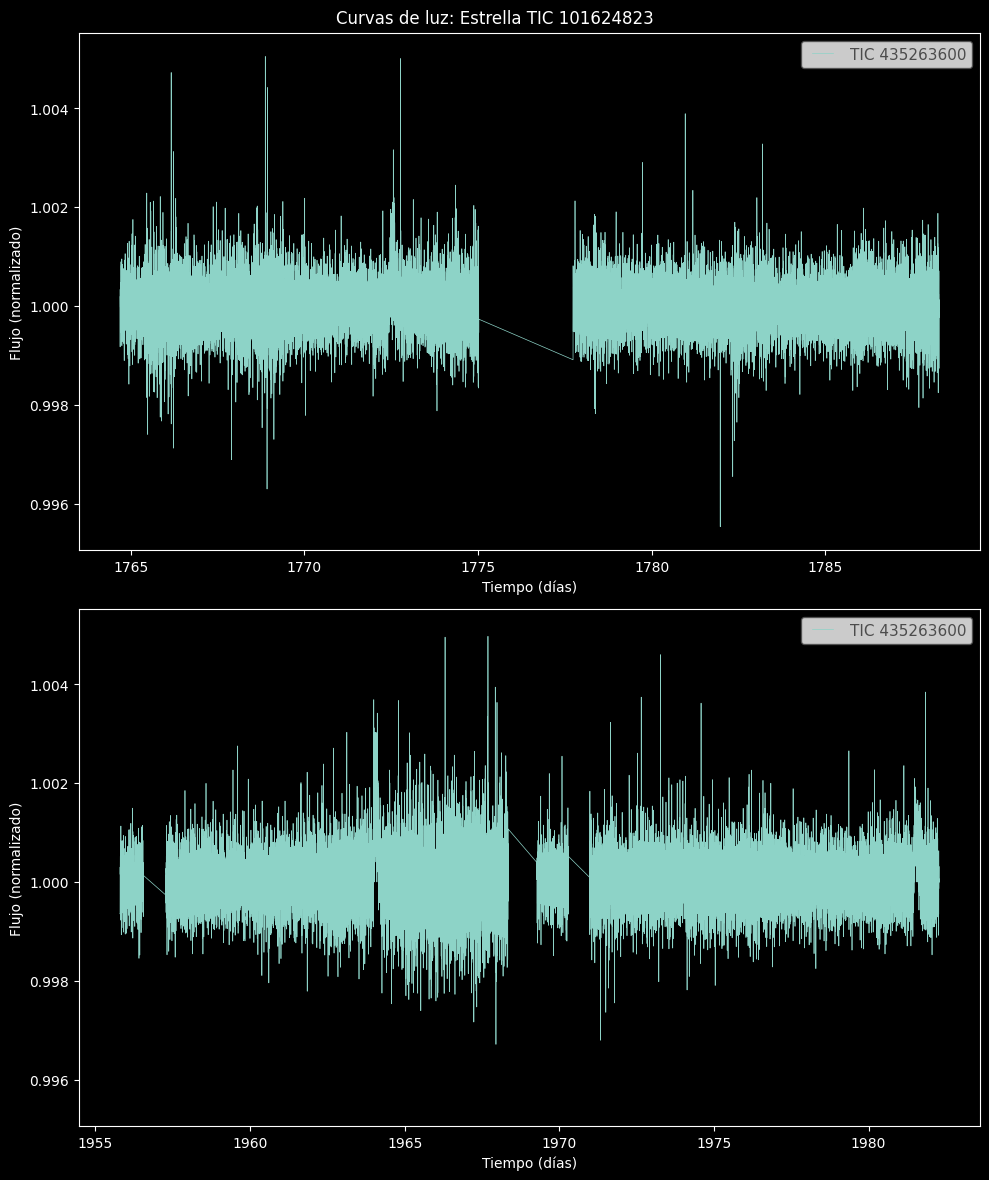

In [43]:
fig, axes = plt.subplots(nrows=len(lightcurves),ncols=1,sharey=True, figsize=(10,12))
for i,lc in enumerate(lightcurves):
    lc.plot(ax=axes[i])
    axes[i].set(xlabel="Tiempo (días)", ylabel="Flujo (normalizado)")

fig.suptitle(f'Curvas de luz: Estrella {ids[0]}')
plt.tight_layout()
plt.show()

Para explorar cosas como la frecuencia y el periodo realizamos una transformada de Fourier específica: el periodograma.

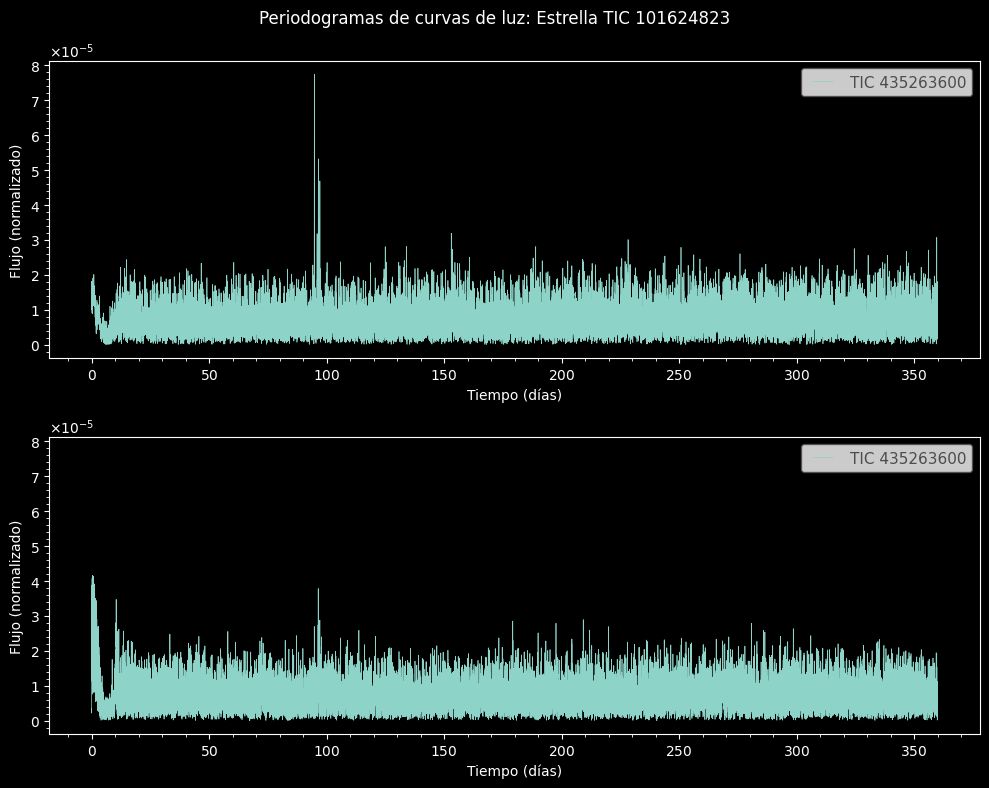

In [42]:
#plt.style.use('dark_background')
fig, axes = plt.subplots(nrows=len(lightcurves), ncols=1, sharey=True, figsize=(10,8))
for i,lc in enumerate(lightcurves):
    lc.to_periodogram().plot(ax=axes[i])
    axes[i].set(xlabel="Tiempo (días)", ylabel="Flujo (normalizado)")

fig.suptitle(f'Periodogramas de curvas de luz: Estrella {ids[0]}')
plt.tight_layout()
plt.show()

Ahora que tenemos una idea de qué es lo que buscamos, podemos empezar a generalizar este procedimiento para múltiples estrellas.

## Parte 2: Generalización a múltiples ID's

In [16]:
#Paqueterías necesarias
from scipy.signal import find_peaks
from astroquery.mast import Catalogs
import numpy as np

In [17]:
#Arreglos a utilizar 
average_frequency = [] 
average_period = []
teff_list = []
logg_list = []
valid_ids = []

In [18]:
#Obtenemos distintos parámetros de las estrellas a analizar
def get_star_params(tic_id):
    catalog_data = Catalogs.query_object(f"{tic_id}", catalog="TIC")
    if len(catalog_data) > 0:
        teff = catalog_data[0]['Teff']
        logg = catalog_data[0]['logg']
        return teff, logg
    else:
        return None, None

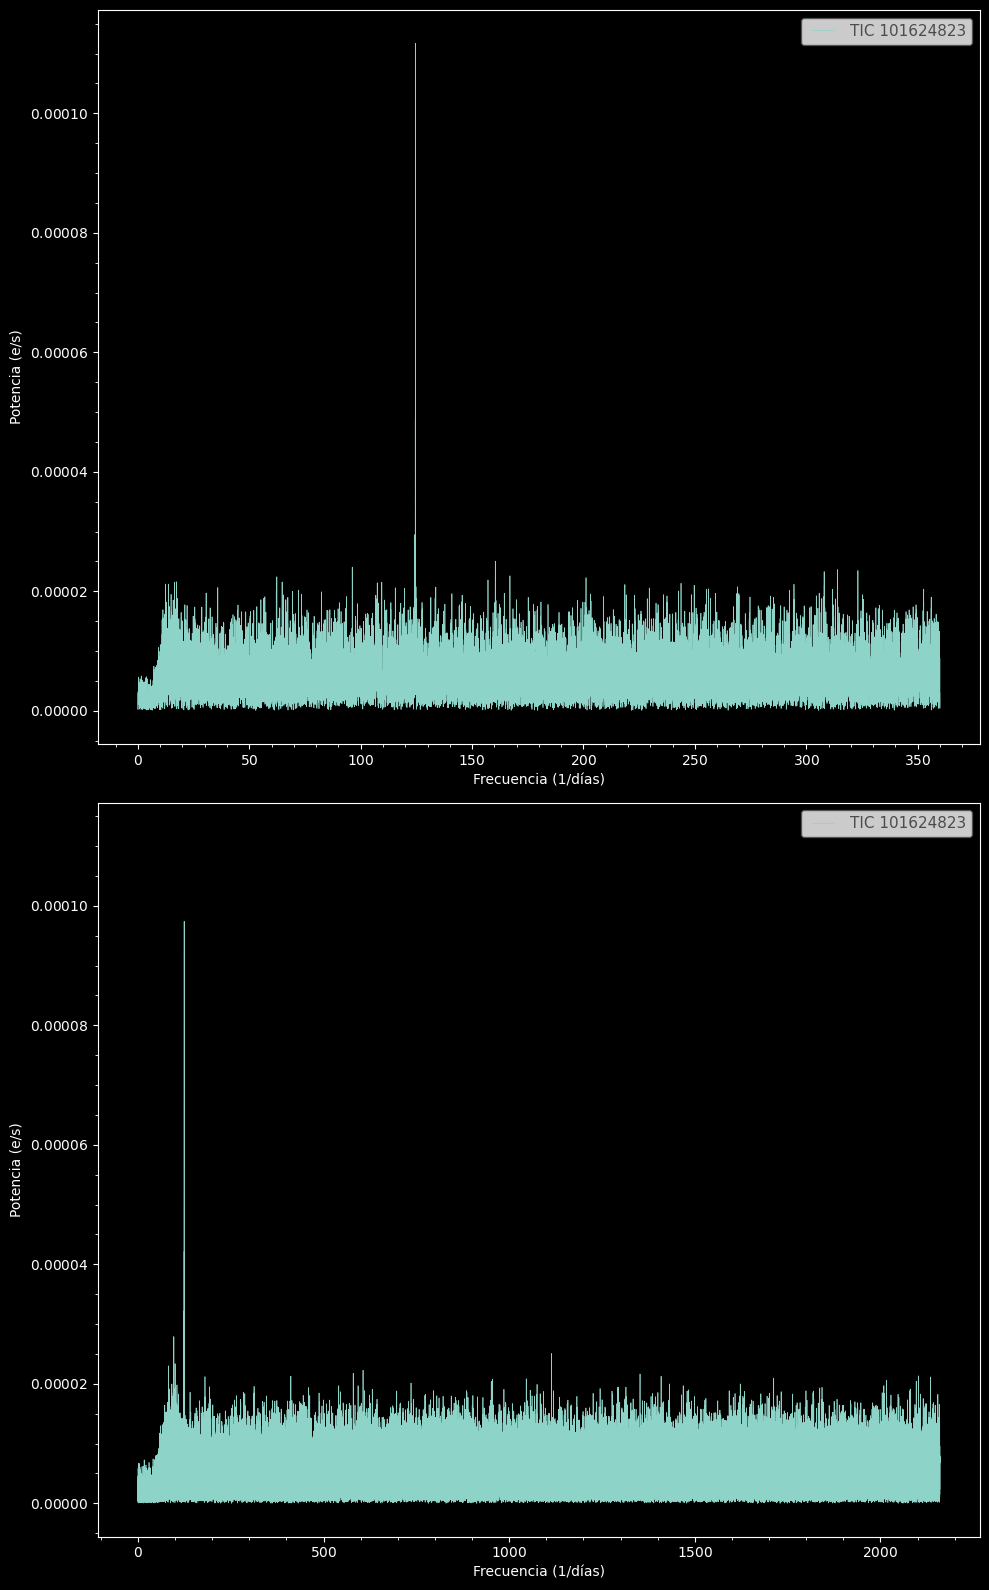

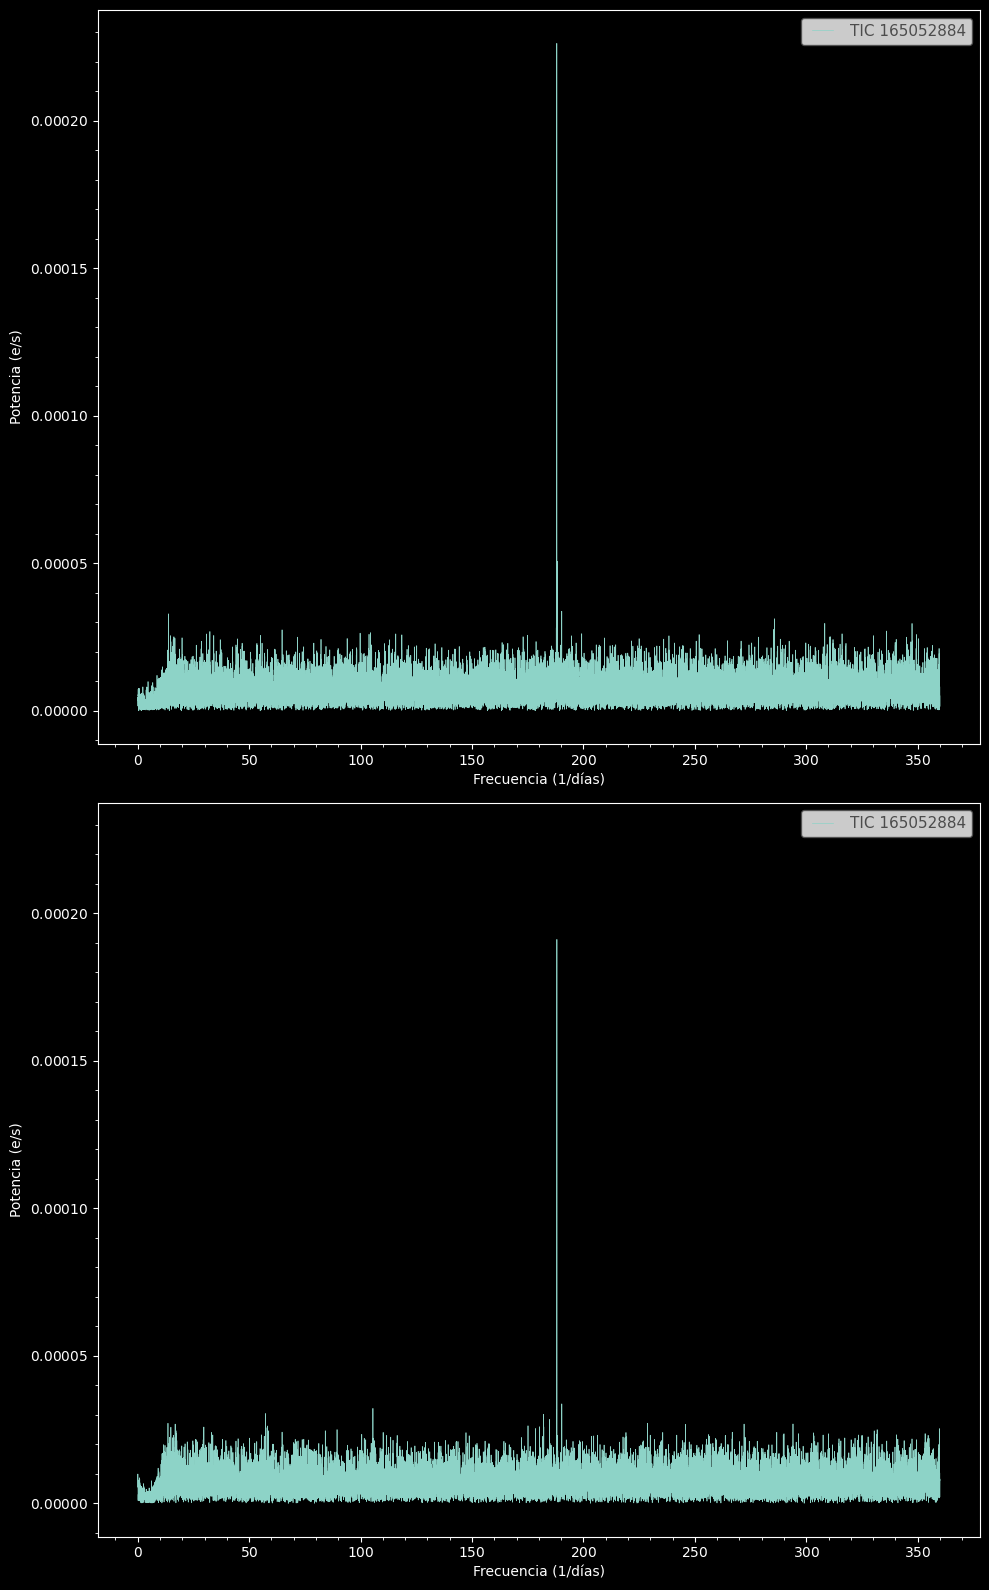

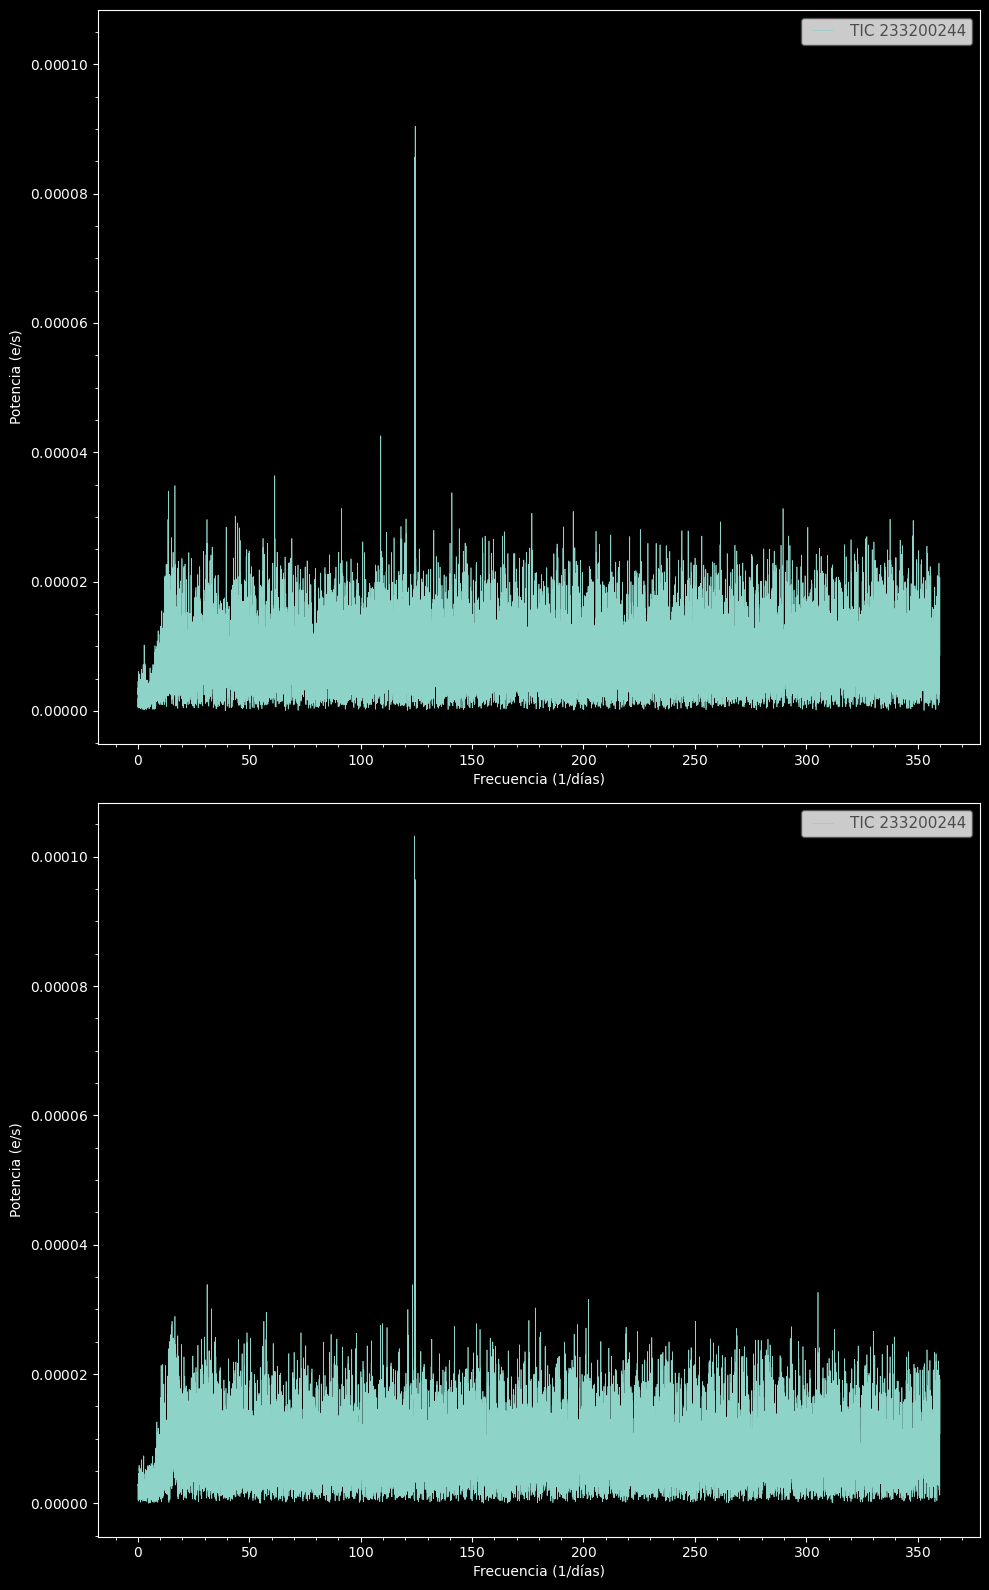

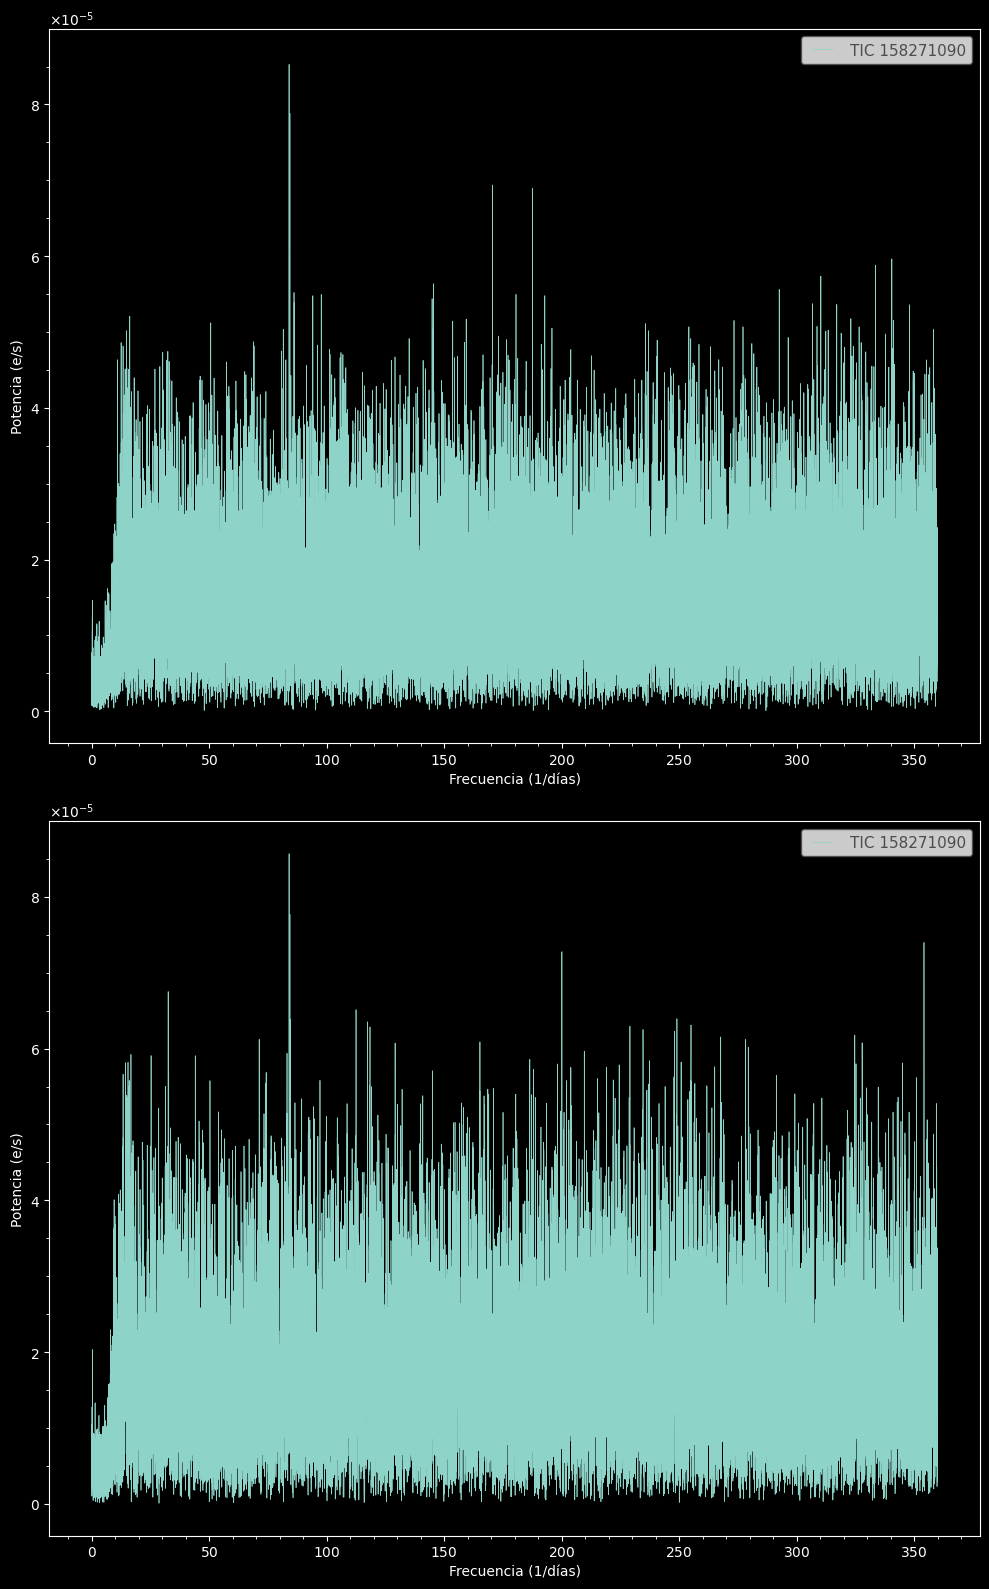

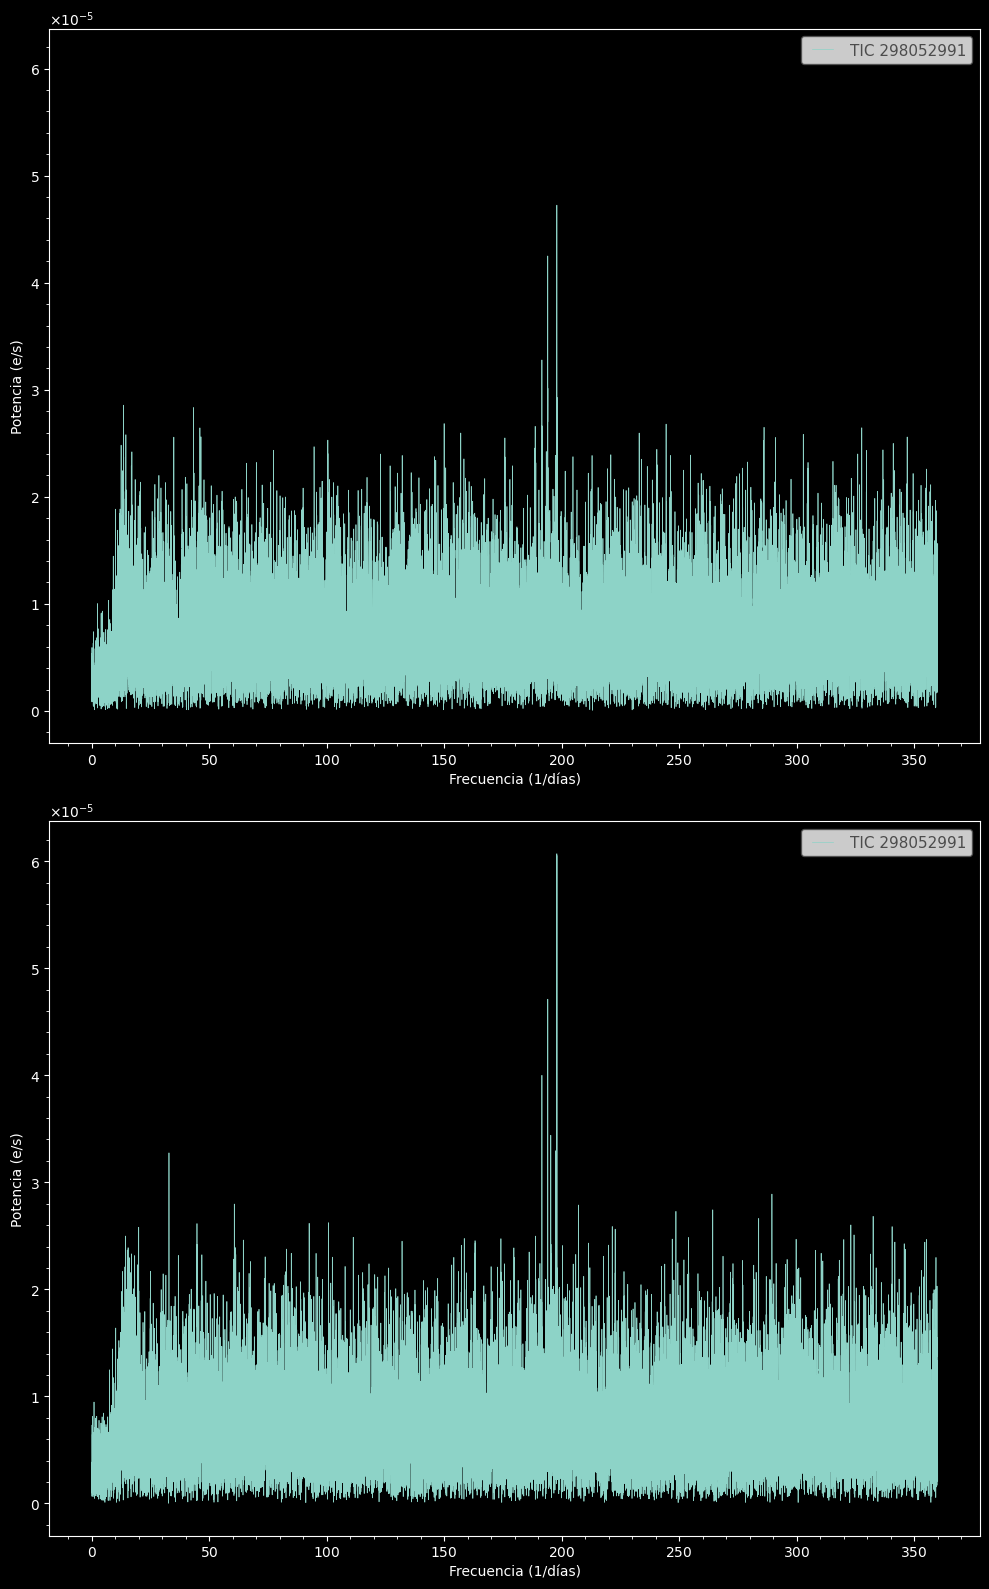

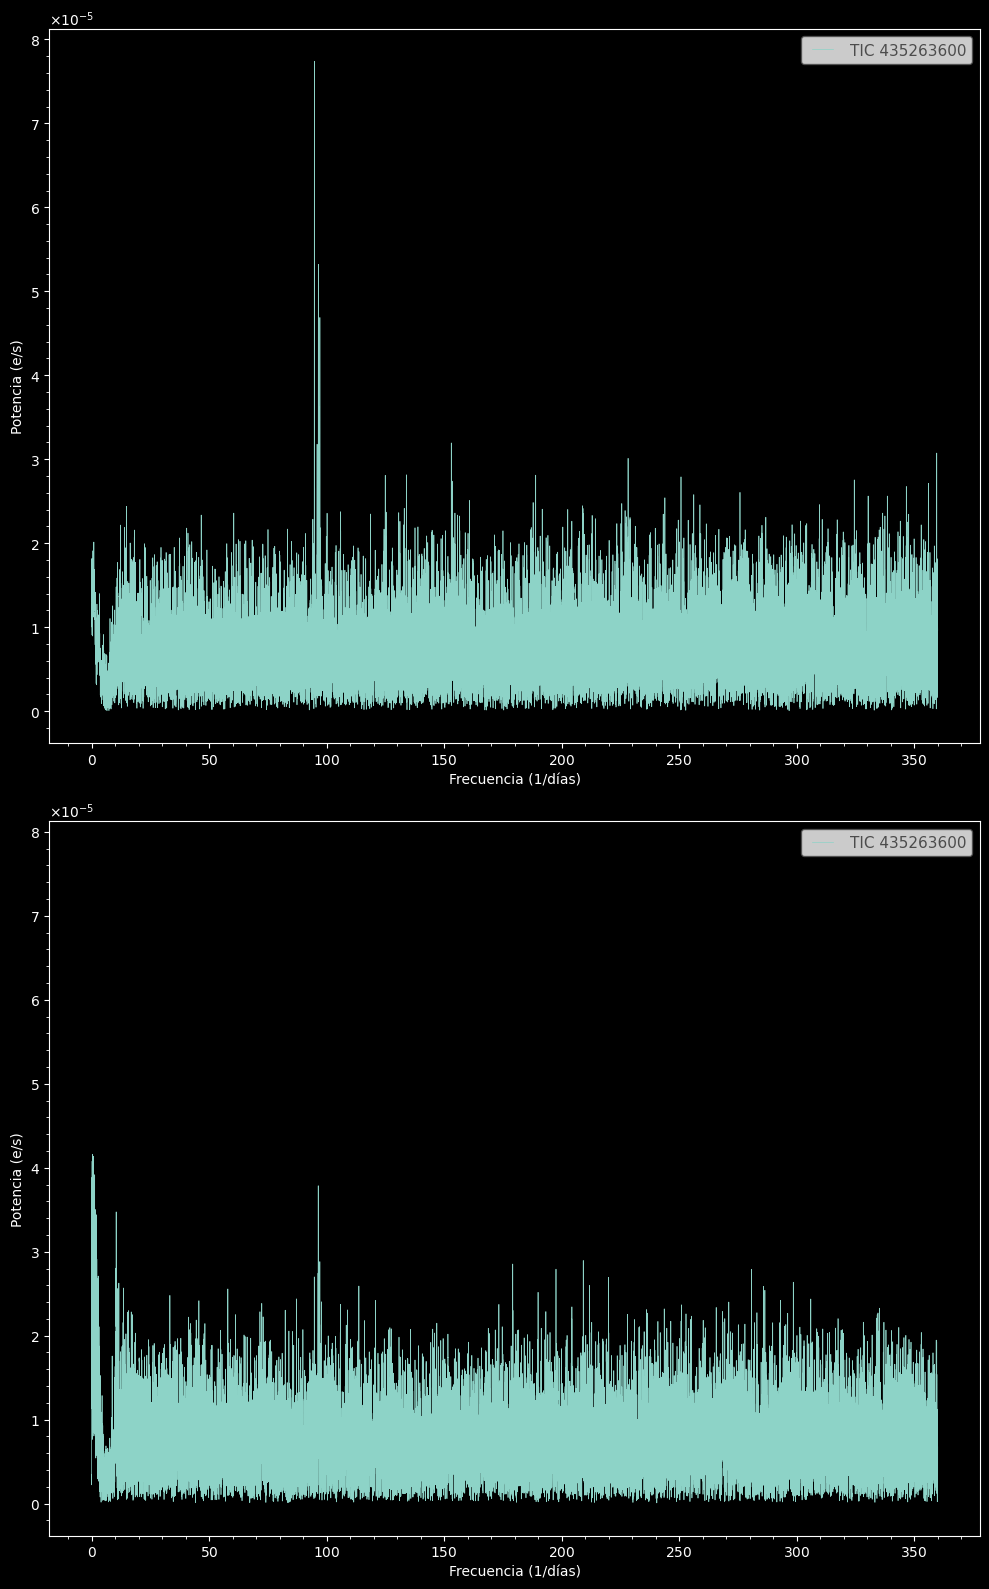

Frecuencias promedio: [118.93245313509246, 188.08759539177822, 124.33284051493222, 194.54899906845546, 0.613555445802346, 118.93245313509246, 188.08759539177822, 124.33284051493222, 194.54899906845546, 0.613555445802346]
Períodos promedio: [0.008494930825892545, 0.0053166721091468215, 0.0080429339490675, 0.005141015366191619, 2.8089250158171932, 0.008494930825892545, 0.0053166721091468215, 0.0080429339490675, 0.005141015366191619, 2.8089250158171932]
Temperaturas efectivas: [6776.0, 6898.0, 8218.0, 7386.98, 7596.0, nan, 6776.0, 6898.0, 8218.0, 7386.98, 7596.0, nan]
Gravedad superficial: [3.83447, 4.17896, 4.06512, 3.73299, 4.30573, nan, 3.83447, 4.17896, 4.06512, 3.73299, 4.30573, nan]


In [44]:
#P
for id in ids:
    search_result = lk.search_lightcurve(id, mission="TESS", author="SPOC",exptime="120")
    lightcurves = [item.download().remove_nans().remove_outliers().flatten() for item in search_result[0:2]]
    
    fig, axes = plt.subplots(nrows=len(lightcurves), ncols=1, sharey=True, figsize=(10, 8 * len(lightcurves)))

    for i, lc in enumerate(lightcurves):
        periodogram = lc.to_periodogram()
        periodogram.plot(ax=axes[i])
        axes[i].set(xlabel="Frecuencia (1/días)", ylabel="Potencia (e/s)")
    
    frequencies = periodogram.frequency.value
    power = periodogram.power.value
    
    peaks, _ = find_peaks(power, height = np.median(power)*5)
    peak_freqs = frequencies[peaks]
    peak_powers = power[peaks]
    peak_periods = 1/peak_freqs

    if len(peak_freqs) > 0:
        average_frequency.append(np.mean(peak_freqs))
        average_period.append(np.mean(peak_periods))
        valid_ids.append(id)

    # Obtener la temperatura efectiva y la luminosidad
    teff, logg = get_star_params(id)
    if teff is not None and logg is not None:
        teff_list.append(teff)
        logg_list.append(logg)

    plt.tight_layout()
    plt.show()

print(f"Frecuencias promedio: {average_frequency}")
print(f"Períodos promedio: {average_period}")
print(f"Temperaturas efectivas: {teff_list}")
print(f"Gravedad superficial: {logg_list}")

## Parte III: Diagrama HR

Una vez obtenido la frecuencia y el periodo de estas estrellas, podemos usar datos conocidos de estas estrellas para hallar su tenperatura y gravedad, y crear un diagrama HR de estas estrellas.

In [20]:
from adjustText import adjust_text

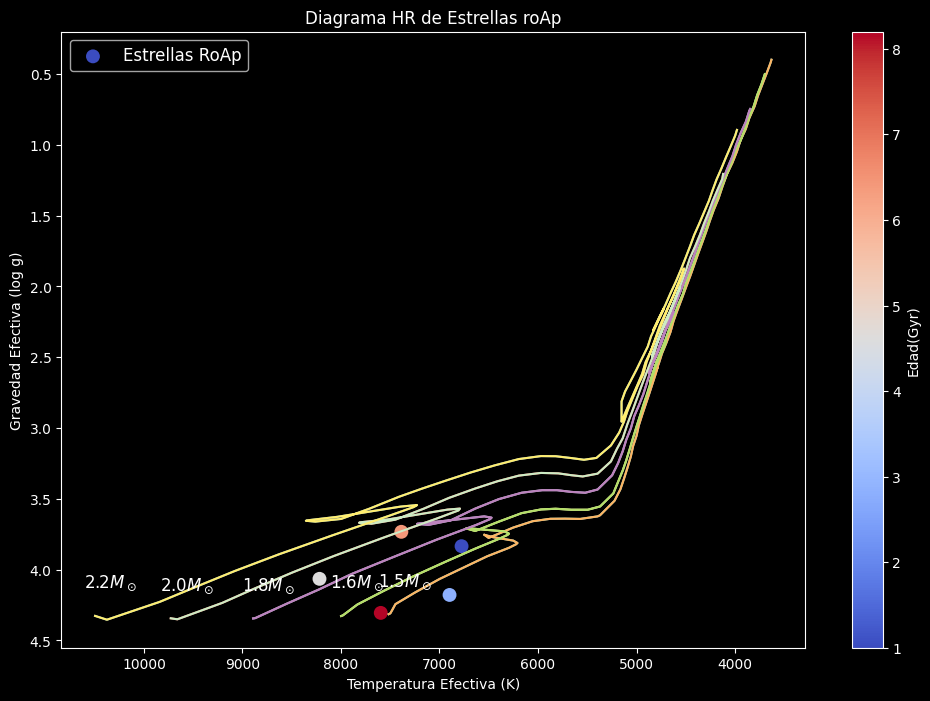

In [39]:
import pandas as pd
import os

#Función para cargar y limpiar los datos evolutivos
def load_and_clean_evolutionary_track(file_path):
    columns = ['age/yr', 'logL', 'logTeff', 'grav', 'logTc', 'logrho', 'Xc,Yc', 'Xc_C', 'Xc_O', 'Q_conv', 'Q_disc',
               'logL_H', 'Q1_H', 'Q2_H', 'logL_He', 'Q1_He', 'Q2_He', 'logL_C', 'logL_nu', 'Q_Tmax', 'stage']
    
    #df = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=columns, usecols=['logTeff', 'grav', 'logL', 'stage', 'age/yr'])
    df = pd.read_csv(file_path, sep=r'\s+', comment='#', names=columns, usecols=['logTeff', 'grav', 'logL', 'stage', 'age/yr'])    
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

# Definimos rutas de archivos
base_dir = "/home/usuario/Downloads/sequences/"
file_paths = [
    (os.path.join(base_dir, "ms0150z019a.dat"), "$1.5M_\\odot$"),
    (os.path.join(base_dir, "ms0160z019a.dat"), "$1.6M_\\odot$"),
    (os.path.join(base_dir, "ms0180z019a.dat"), "$1.8M_\\odot$"),
    (os.path.join(base_dir, "ms0200z019a.dat"), "$2.0M_\\odot$"),
    (os.path.join(base_dir, "ms0220z019a.dat"), "$2.2M_\\odot$")
]

# Ensure the paths are correct
for path, label in file_paths:
    if not os.path.isfile(path):
        print(f"Error: {path} es una ruta no válida.")
        continue

#Cargamos datos evolutivos
tracks = [(load_and_clean_evolutionary_track(path), label) for path, label in file_paths if os.path.isfile(path)]

# Diagrama HR
plt.style.use('dark_background')
plt.figure(figsize=(12, 8))

# Rutas evolutivas con masas asociadas 
for track, label in tracks:
    plt.plot(10**track['logTeff'], track['grav'], label=None)

    # Find a finite value for labeling
    for i in range(len(track)):
        if np.isfinite(10**track['logTeff'].iloc[i]) and np.isfinite(track['grav'].iloc[i]):
            plt.text(10**track['logTeff'].iloc[i]+110, track['grav'].iloc[i]-0.2, label, fontsize=12, color='white')
            break

for track, label in tracks:
    valid_indices = np.isfinite(10**track['logTeff']) & np.isfinite(track['grav'])
    plt.plot(10**track['logTeff'][valid_indices], track['grav'][valid_indices], label=None)
    if np.isfinite(10**track['logTeff'].iloc[0]) and np.isfinite(track['grav'].iloc[0]):
        plt.text(10**track['logTeff'].iloc[0], track['grav'].iloc[0], label, fontsize=12, color='black')


star_age = np.linspace(1, 10, len(teff_list))  # Map
sc = plt.scatter(teff_list, logg_list, c=star_age, cmap='coolwarm', edgecolors='none', s=100 ,label="Estrellas RoAp")

# Formato de la gráfica
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Temperatura Efectiva (K)')
plt.ylabel('Gravedad Efectiva (log g)')
plt.title('Diagrama HR de Estrellas roAp')
plt.colorbar(sc, label='Edad(Gyr)')
plt.legend(loc='best',fontsize=12)
plt.grid(False)

plt.show()

Vemos que estas estrellas, que tienen frecuencias similares, poseen un comportamiento similar, pues parecen encontrarse en la secuencia principal.